 # Анализ результата A/B теста

**Основная цель проекта** — провести оценку результатов A/B-теста. 
**Нам необходимо:** 

- проверить соответствие полученных данных техническому заданию; 
- оценить влияние внешних факторов; 
- выяснить, увеличилась ли конверсия каждого этапа в связи с введенным нововведением. 

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

## Техническое задание

- Название теста: `recommender_system_test`;
- группы: А — контрольная, B — новая платёжная воронка;
- дата запуска: 2020-12-07;
- дата остановки набора новых пользователей: 2020-12-21;
- дата остановки: 2021-01-04;
- аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU;
- назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
- ожидаемое количество участников теста: 6000.
- ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    - конверсии в просмотр карточек товаров — событие `product_page`,
    - просмотры корзины — `product_cart`,
    - покупки — `purchase`.

## Описание данных

`ab_project_marketing_events.csv` — календарь маркетинговых событий на 2020 год.

Структура файла:

- `name` — название маркетингового события;
- `regions` — регионы, в которых будет проводиться рекламная кампания;
- `start_dt` — дата начала кампании;
- `finish_dt` — дата завершения кампании.

`final_ab_new_users.csv` — пользователи, зарегистрировавшиеся с 7 по 21 декабря 2020 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `first_date` — дата регистрации;
- `region` — регион пользователя;
- `device` — устройство, с которого происходила регистрация.

`final_ab_events.csv` — действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года.

Структура файла:

- `user_id` — идентификатор пользователя;
- `event_dt` — дата и время события;
- `event_name` — тип события;
- `details` — дополнительные данные о событии. Например, для покупок, `purchase,` в этом поле хранится стоимость покупки в долларах.

`final_ab_participants.csv` — таблица участников тестов.

Структура файла:

- `user_id` — идентификатор пользователя;
- `ab_test` — название теста;
- `group` — группа пользователя.



## План проекта
1. [Загрузка данных и изучение общей информации](#start)
2. [Предобработка данных](#preprocessing)
    - [Преобразование типов](#types)
    - [Описание природы пропущенных значений и дубликатов, если они есть.](#nansdupls)
    - [Периоды, за которые представлены данные](#periods)
3. [Оценка корректности проведения теста.](#correctness)
    - [Соответствие данных требованиям технического задания. Проверка корректности всех пунктов технического задания.](#tz)
    - [Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.](#time)
    - [Аудитория теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.](#aud)
4. [Исследовательский анализ данных](#analysis)
    - [Количество событий на пользователя одинаково распределены в выборках?](#eventsbyuser)
    - [Как число событий в выборках распределено по дням?](#eventsbyday)
    - [Как меняется конверсия в воронке в выборках на разных этапах?](#conversion)
    - [Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?](#peculiar)
5. [Оценка результатов A/B-тестирования](#results)
    - [Что можно сказать про результаты A/В-тестирования?](#middleresults)
    - [Проверьте статистическую разницу долей z-критерием.](#test)
6. [Выводы](#conclusions)

## [Загрузка данных и изучение общей информации](#start)
<a id="start"><a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
from matplotlib import pyplot as plt
from scipy import stats as st
import os
import plotly.express as px
from plotly import graph_objects as go
import math as mth

In [2]:
pth1 = 'ab_project_marketing_events.csv'
pth2 = 'final_ab_new_users.csv'
pth3 = 'final_ab_events.csv'
pth4 = 'final_ab_participants.csv'

marketing_events = pd.read_csv(pth1)
new_users = pd.read_csv(pth2)
events = pd.read_csv(pth3)
participants = pd.read_csv(pth4)


### Общая информация по календарю маркетинговых событий за 2020 год

In [3]:
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   name       14 non-null     object
 1   regions    14 non-null     object
 2   start_dt   14 non-null     object
 3   finish_dt  14 non-null     object
dtypes: object(4)
memory usage: 576.0+ bytes


In [4]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


**В датасете представлено 14 маркетинговых событий. Сразу видим, что столбцы с началом и концом событий не соответствуют типу datetime**

### Общая информация по пользователям, зарегистрировавшимся с 7 по 21 декабря 2020 года

In [5]:
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     61733 non-null  object
 1   first_date  61733 non-null  object
 2   region      61733 non-null  object
 3   device      61733 non-null  object
dtypes: object(4)
memory usage: 1.9+ MB


In [6]:
new_users.shape

(61733, 4)

In [7]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [8]:
new_users['region'].unique()

array(['EU', 'N.America', 'APAC', 'CIS'], dtype=object)

In [9]:
new_users['device'].unique()

array(['PC', 'Android', 'iPhone', 'Mac'], dtype=object)

**В данных представлено 61733 строк и 4 столбца. Снова видим, что столбец first_date нужно будет преобразовать к типу datetime. Всего представлено 4 региона:**
- EU - Европейский союз;
- N.America - Северная Америка
- APAC - Азиaтско-Тихоокеанский регион
- CIS - страны СНГ

**Всего 4 устройства с которых проходила регистрация:'PC', 'Android', 'iPhone', 'Mac'**

### Общая информация по действиям новых пользователей в период с 7 декабря 2020 по 4 января 2021 года

In [10]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   user_id     440317 non-null  object 
 1   event_dt    440317 non-null  object 
 2   event_name  440317 non-null  object 
 3   details     62740 non-null   float64
dtypes: float64(1), object(3)
memory usage: 13.4+ MB


In [11]:
events.shape

(440317, 4)

In [12]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [13]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

**В данных представлено 440317 строк, 4 столбца.Дата события не соответствует типу datetime. Видим, что данных в столбце с деталями меньше, чем в остальных столбцах датасета (природу пропусков проанализируем позже). Всего 4 типа события:**
- purchase - покупка;
- product_cart - корзина;
- product_page - страница продукта;
- login - вход в аккаунт.

### Общая информация об участниках теста

In [14]:
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18268 entries, 0 to 18267
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  18268 non-null  object
 1   group    18268 non-null  object
 2   ab_test  18268 non-null  object
dtypes: object(3)
memory usage: 428.3+ KB


In [15]:
participants.head()

,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [16]:
participants.shape

(18268, 3)

In [17]:
participants['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

In [18]:
participants.query('ab_test == "recommender_system_test"')['group'].unique()

array(['A', 'B'], dtype=object)

In [19]:
participants.query('ab_test == "interface_eu_test"')['group'].unique()

array(['A', 'B'], dtype=object)

**В данных 18268 строк, 3 столбца. Всего представлено два типа тестов: 'recommender_system_test' и  'interface_eu_test'. Оба теста парные.**

## Предобработка данных
<a id="preprocessing"><a>

### Преобразование типов
<a id="types"><a>

**Преобразуем столбцы с датами к типу datetime**

In [20]:
marketing_events['start_dt'] = marketing_events['start_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events['finish_dt'] = marketing_events['finish_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
marketing_events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes


In [21]:
new_users['first_date'] = new_users['first_date'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d'))
new_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 1.9+ MB


In [22]:
events['event_dt'] = events['event_dt'].map(lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440317 entries, 0 to 440316
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     440317 non-null  object        
 1   event_dt    440317 non-null  datetime64[ns]
 2   event_name  440317 non-null  object        
 3   details     62740 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(2)
memory usage: 13.4+ MB


### Описание природы пропущенных значений и дубликатов, если они есть
<a id="nansdupls"><a>


#### Пропуски

In [23]:
marketing_events.isna().sum()

name         0
regions      0
start_dt     0
finish_dt    0
dtype: int64

In [24]:
new_users.isna().sum()

user_id       0
first_date    0
region        0
device        0
dtype: int64

In [25]:
events.isna().sum()

user_id            0
event_dt           0
event_name         0
details       377577
dtype: int64

In [26]:
participants.isna().sum()

user_id    0
group      0
ab_test    0
dtype: int64

**Итак, пропуски есть только в столбце details датасета с действиями пользователей**

In [27]:
events.query('details.isna()')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [28]:
events.query('not details.isna()')['event_name'].unique()

array(['purchase'], dtype=object)

**Видим, что пропусков в деталях нет только для покупок - там указывается их стоимость в долларах. Заключаем, что пропуски связаны с тем, что для других категорий никаких деталей не отмечается. Оставим пропущенные значения, как есть**

#### Дубликаты

In [29]:
marketing_events.duplicated().sum()

0

In [30]:
marketing_events['name'].duplicated().sum()

0

In [31]:
marketing_events.head()

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11


**Дубликатов в таблице с маркетинговыми событиями нет, все 14 событий также различны**

In [32]:
new_users.duplicated().sum()

0

In [33]:
new_users['user_id'].duplicated().sum()

0

In [34]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


**Дубликатов в таблице с данными о зарегистрировавшихся пользователях также нет, повторяющиеся пользователи отсутствуют.**

In [35]:
events.duplicated().sum()

0

In [36]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [37]:
events[['user_id', 'event_dt']].duplicated().sum()

151233

In [38]:
events[['user_id', 'event_dt', 'event_name']].duplicated().sum()

0

**Явных дубликатов в таблице с действиями пользователей нет, на дубликаты в отдельных стобцах проверять не будем - один пользователь может совершить несколько действий и несколько раз попасть в таблицу, время, тип события и детали также могут совпадать. Есть неявные дубликаты - пользователи, которые совершили несколько действий в одно время. Это можно объяснить тем, что браузер этих пользователей не фиксирует время каждого события.**

In [39]:
participants.duplicated().sum()

0

In [40]:
participants['user_id'].duplicated().sum()

1602

In [41]:
participants[['user_id', 'ab_test']].duplicated().sum()

0

**Пользователей, которые учитываются в одном тесте несколько раз, нет**

### Периоды, за которые представлены данные
<a id="periods"><a>

In [42]:
new_users.head()

,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone


In [43]:
print(f'Первая зафиксированная дата регистрации: {new_users["first_date"].dt.date.min()}')
print(f'Последняя зафиксированная дата регистрации: {new_users["first_date"].dt.date.max()}')
print(f'Длина периода: {(new_users["first_date"].dt.date.max() - new_users["first_date"].dt.date.min())}')


Первая зафиксированная дата регистрации: 2020-12-07
Последняя зафиксированная дата регистрации: 2020-12-23
Длина периода: 16 days, 0:00:00


In [44]:
events.head()

,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99


In [45]:
print(f'Дата первого зафиксированного события: {events["event_dt"].dt.date.min()}')
print(f'Дата последнего зафиксированного события: {events["event_dt"].dt.date.max()}')
print(f'Длина периода фиксации событий: {(events["event_dt"].dt.date.max() - events["event_dt"].dt.date.min())}')

Дата первого зафиксированного события: 2020-12-07
Дата последнего зафиксированного события: 2020-12-30
Длина периода фиксации событий: 23 days, 0:00:00


In [46]:
marketing_events

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11
5,Black Friday Ads Campaign,"EU, CIS, APAC, N.America",2020-11-26,2020-12-01
6,Chinese New Year Promo,APAC,2020-01-25,2020-02-07
7,Labor day (May 1st) Ads Campaign,"EU, CIS, APAC",2020-05-01,2020-05-03
8,International Women's Day Promo,"EU, CIS, APAC",2020-03-08,2020-03-10
9,Victory Day CIS (May 9th) Event,CIS,2020-05-09,2020-05-11


## Оценка корректности проведения теста.
<a id="correctness"><a>

### Соответствие данных требованиям технического задания. Проверка корректности всех пунктов технического задания.
<a id="tz"><a>

**Создадим что-то вроде профилей пользователей, чтобы было удобнее по ним отсекать ненужное. Сразу же добавим туда лайфтайм.**

In [47]:
profile = new_users.merge(
        events,
        on='user_id',
        how='left',
    )
profile['lifetime'] = (
    profile['event_dt'] - profile['first_date']
    ).dt.days
profile['lifetime'] = (
    profile['event_dt'] - profile['first_date']
    ).dt.days
#profile = profile.query('lifetime < 14')
profile =  profile.merge(
        participants,
        on='user_id',
        how='left',
    )
profile['event_date'] = profile['event_dt'].dt.date
profile.head()

,user_id,first_date,region,device,event_dt,event_name,details,lifetime,group,ab_test,event_date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,0.0,A,recommender_system_test,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,0.0,A,recommender_system_test,2020-12-07
2,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-07 16:38:09,product_page,NaN,0.0,NaN,NaN,2020-12-07
3,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-08 02:02:34,product_page,NaN,1.0,NaN,NaN,2020-12-08
4,F1C668619DFE6E65,2020-12-07,N.America,Android,2020-12-23 14:35:41,product_page,NaN,16.0,NaN,NaN,2020-12-23


#### Название теста: recommender_system_test

**Уберем из профилей участников конкурентного теста**

In [48]:
profile = profile.query('ab_test == "recommender_system_test" ')
profile.head()

,user_id,first_date,region,device,event_dt,event_name,details,lifetime,group,ab_test,event_date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,0.0,A,recommender_system_test,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,0.0,A,recommender_system_test,2020-12-07
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,NaN,B,recommender_system_test,NaT
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,0.0,B,recommender_system_test,2020-12-07
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,NaN,1.0,B,recommender_system_test,2020-12-08


In [49]:
profile['user_id'].nunique()

6701

<div class="alert alert-info"> <b>Комментарии студента:</b> Проверка соответствия ТЗ до отчистки данных:</div>

#### Проверим соответствие ТЗ до очистки данных

In [50]:
print('Ожидаемое количество пользователей теста: 6000, реальное количество:', profile['user_id'].nunique())

Ожидаемое количество пользователей теста: 6000, реальное количество: 6701


In [51]:
print('По техническому заданию дата запуска теста: 2020-12-07, Дата окончания теста: 2021-01-04')
print('Дата первого зафиксированного события:', profile.dropna()['event_date'].min())
print('Дата последнего зафиксированного события:', profile.dropna()['event_date'].max())

По техническому заданию дата запуска теста: 2020-12-07, Дата окончания теста: 2021-01-04
Дата первого зафиксированного события: 2020-12-07
Дата последнего зафиксированного события: 2020-12-29


Видим несостыковку: тест заканчивается 4 января, а данные мы перестаем принимать 29 декабря

In [52]:
print('По техническому заданию дата последней регистрации - 21 декабря')
print('Дата первой регистрации:', profile['first_date'].min())
print('Дата последней регистрации:', profile['first_date'].max())

По техническому заданию дата последней регистрации - 21 декабря
Дата первой регистрации: 2020-12-07 00:00:00
Дата последней регистрации: 2020-12-21 00:00:00


Тут все хорошо, противоречий нет

In [53]:
print('По техническому заданию участники нашего теста - европейцы. \n На самом деле, распределение по регионам следующее:')
profile.groupby('region')[['user_id']].nunique()

По техническому заданию участники нашего теста - европейцы. 
 На самом деле, распределение по регионам следующее:


,user_id
region,
APAC,72
CIS,55
EU,6351
N.America,223


Посмотрим на долю участников теста из Европы от всех зарегистрировавшихся вовремя европейцев

In [54]:
start_date = pd.to_datetime('2020-12-07', format = "%Y-%m-%d")
stop_date = pd.to_datetime('2020-12-21', format = "%Y-%m-%d")
print('Доля участников теста от всех зарегистрировашихся вовремя европейцев:', profile.query('region=="EU"')['user_id'].nunique()/len(new_users.query('first_date <= @stop_date and region == "EU"')))

Доля участников теста от всех зарегистрировашихся вовремя европейцев: 0.15


Все хорошо, противоречий нет

#### Лайфтайм пользователей - 14 дней

In [55]:
profile.query('lifetime > 14')["user_id"].nunique()

270

**Уберем события, которые произошли после 14 лайфтайма**

In [56]:
profile = profile.query('not lifetime > 14')

In [57]:
profile.head()

,user_id,first_date,region,device,event_dt,event_name,details,lifetime,group,ab_test,event_date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,0.0,A,recommender_system_test,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,0.0,A,recommender_system_test,2020-12-07
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,NaN,B,recommender_system_test,NaT
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,0.0,B,recommender_system_test,2020-12-07
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,NaN,1.0,B,recommender_system_test,2020-12-08


#### дата запуска теста: 2020-12-07, дата окончания теста: 2021-01-04

**Посмотрим, в какие даты фиксировались действия пользователей**

In [58]:
print('Дата первого зафиксированного события:', profile['event_dt'].dropna().dt.date.min())
print('Дата последнего зафиксированного события:', profile['event_dt'].dropna().dt.date.max())

Дата первого зафиксированного события: 2020-12-07
Дата последнего зафиксированного события: 2020-12-29


#### аудитория: в тест должно быть отобрано 15% новых пользователей из региона EU

**Участники нашего теста - пользователи из Европы, причем количество участников теста составляет 15% от всех зарегистрированных в нужное время европейцев. Так как мы уже знаем, что самая ранняя дата регистрации всех пользователей совпадает с началом теста, будем отсекать только по остановке набора новых пользователей - 21 декабря 2020 года**

In [59]:
start_date = pd.to_datetime('2020-12-07', format = "%Y-%m-%d")
stop_date = pd.to_datetime('2020-12-21', format = "%Y-%m-%d")
profile = profile.query('region == "EU"')
print('Доля участников теста от всех зарегистрировашихся вовремя европейцев:', profile['user_id'].nunique()/len(new_users.query('first_date <= @stop_date and region == "EU"')))

Доля участников теста от всех зарегистрировашихся вовремя европейцев: 0.15


#### Ожидаемое количество участников теста:6000

In [60]:
print('Количество участников теста:', profile['user_id'].nunique())
print('Количество участников контрольной группы:', profile.query('group =="A"')['user_id'].nunique())
print('Количество участников тестовой группы:', profile.query('group =="B"')['user_id'].nunique())
print('Доля участников контрольной группы:', profile.query('group =="A"')['user_id'].nunique()/profile['user_id'].nunique())
print('Доля участников тестовой группы:', profile.query('group =="B"')['user_id'].nunique()/profile['user_id'].nunique())

Количество участников теста: 6351
Количество участников контрольной группы: 3634
Количество участников тестовой группы: 2717
Доля участников контрольной группы: 0.5721933553771059
Доля участников тестовой группы: 0.42780664462289403


#### Дата остановки набора новых пользователей: 21 декабря 2020 

In [61]:
profile['first_date'].max()

Timestamp('2020-12-21 00:00:00')

In [62]:
profile['first_date'].min()

Timestamp('2020-12-07 00:00:00')

**Тут все нормально**

### Время проведения теста. Убедимся, что оно не совпадает с маркетинговыми и другими активностями.
<a id="time"><a>

In [63]:
start_date = pd.to_datetime('2020-12-07', format ='%Y-%m-%d')
end_date = pd.to_datetime('2021-01-04', format ='%Y-%m-%d')


In [64]:
marketing_events.query('@end_date >= start_dt >= @start_date or @end_date >= finish_dt >= @start_date')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


**Тест совпал с двумя маркетинговыми событиями - Christmas&New Year Promo и CIS New Year Gift Lottery, однако в Европе проходило только первое.**

In [65]:
profile['event_date'] = profile['event_dt'].dt.date
profile.head()

,user_id,first_date,region,device,event_dt,event_name,details,lifetime,group,ab_test,event_date
0,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:10,product_page,NaN,0.0,A,recommender_system_test,2020-12-07
1,D72A72121175D8BE,2020-12-07,EU,PC,2020-12-07 21:52:07,login,NaN,0.0,A,recommender_system_test,2020-12-07
90,E6DE857AFBDC6102,2020-12-07,EU,PC,NaT,NaN,NaN,NaN,B,recommender_system_test,NaT
146,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-07 15:32:54,product_page,NaN,0.0,B,recommender_system_test,2020-12-07
148,DD4352CDCF8C3D57,2020-12-07,EU,Android,2020-12-08 08:29:31,product_page,NaN,1.0,B,recommender_system_test,2020-12-08


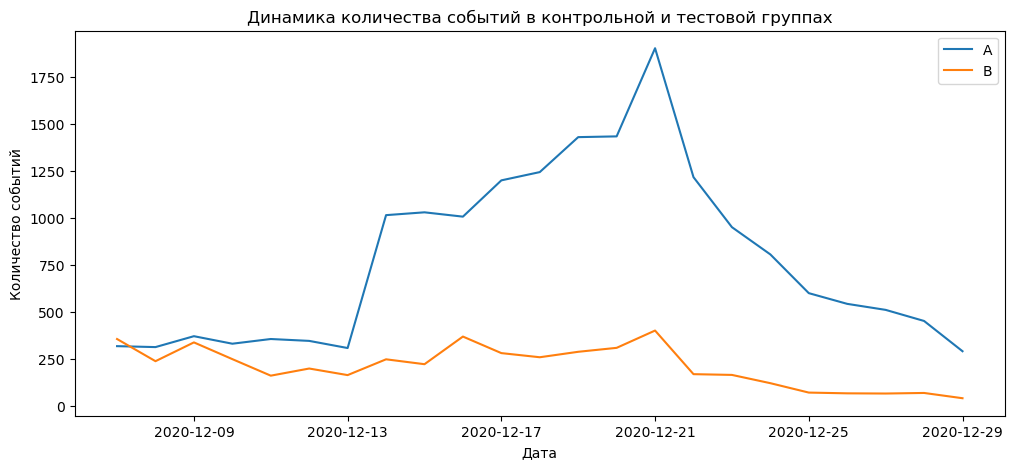

In [66]:
control_group = profile.query('group == "A"')
test_group = profile.query('group == "B"')
plt.figure(figsize =(12,5))
plt.plot(control_group.groupby('event_date', as_index=False)[['event_name']].count()['event_date'],control_group.groupby('event_date', as_index=False)[['event_name']].count()['event_name'], label ="A" )
plt.plot(test_group.groupby('event_date', as_index=False)[['event_name']].count()['event_date'],test_group.groupby('event_date', as_index=False)[['event_name']].count()['event_name'], label = "B" )
plt.title('Динамика количества событий в контрольной и тестовой группах')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend()

**Количество событий контрольной группы с 25 декабря начинает уменьшаться, а в тестовой группе количество действий практически стабильно**

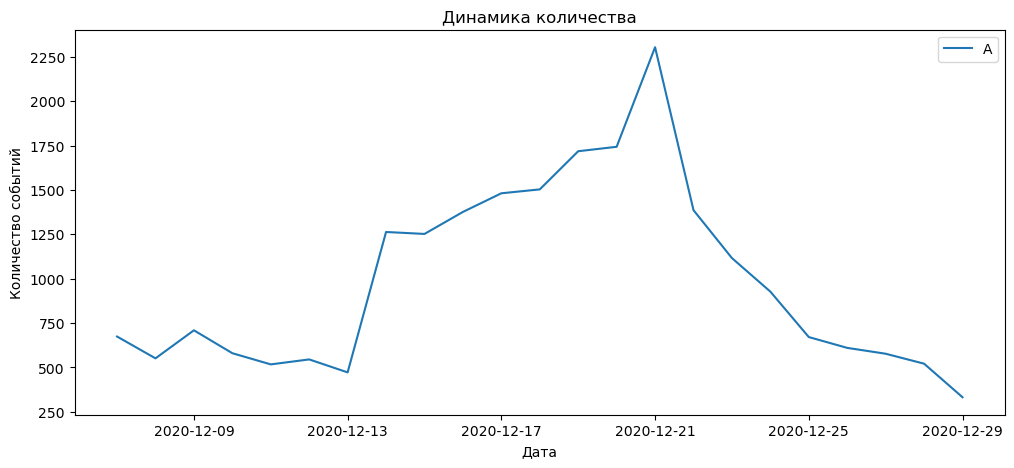

In [67]:
plt.figure(figsize =(12,5))
plt.plot(profile.groupby('event_date', as_index=False)[['event_name']].count()['event_date'], profile.groupby('event_date', as_index=False)[['event_name']].count()['event_name'], label ="A" )
plt.title('Динамика количества')
plt.xlabel('Дата')
plt.ylabel('Количество событий')
plt.legend()

**  **

### Аудитория теста. Удостоверимся, что нет пересечений с конкурирующим тестом и нет пользователей, участвующих в двух группах теста одновременно. Проверим равномерность распределения по тестовым группам и правильность их формирования.
<a id="aud"><a>

In [68]:
interface_eu_test = participants.query('ab_test == "interface_eu_test"')
both_test_participants = interface_eu_test.query('user_id in @profile["user_id"]')
print(f'{len(both_test_participants)} пользователя участвуют в обоих тестах')

ValueError: data type must provide an itemsize

In [ ]:
both_test_participants['group'].value_counts()

**Пользователей из контрольной группы можем оставить, на них второй тест никак не повлиял. Пользователи из тестовой группы второго теста могут исказить результаты, поэтому их учитывать не будем**

In [ ]:
both_test_participants_A = both_test_participants.query('group == "A"')

In [ ]:
profile = profile.query('user_id not in @both_test_participants["user_id"]\
                            or user_id in @both_test_participants_A["user_id"]')

In [ ]:
len(interface_eu_test.query('user_id in @profile["user_id"] and group == "B"'))

In [ ]:
profile.groupby('user_id', as_index = False)[['group']].nunique().query('group!=1')


In [ ]:
cnt = 0
for i in profile.groupby('user_id', as_index = False)[['group']].nunique()['group']:
    if i > 1:
        cnt += 1
print('Количество пересечений в тесте:', cnt)
        

**Очистим профиль пользователей от участников тестовой группы конкуретного теста**

In [ ]:
profile.head()

In [ ]:
profile['user_id'].nunique()

In [ ]:
profile_test_control = profile.groupby('group', as_index=False)[['user_id']].nunique()
profile_test_control['percent'] = round(100 * profile_test_control['user_id']/profile['user_id'].nunique(), 2)

In [ ]:
profile_test_control

**Итак, что в итоге получилось после проверки соответствия ТЗ:**
- собрали пользователей только из теста recommender_system_test 
- отсекли события, которые произошли спустя 14 дней после регистрации пользователей
- отсекли пользователей из всех регионов, кроме Европы. Получилось, что участнки составляют 15% от тех европейцев, которые могли бы потенциально быть участниками нашего теста.
- в итоге набрали в наш тест 6351 человек, что соответствует ТЗ. Распределение по группам получилось неравномерным : 57% в контрольной группе и 43% в тестовой
- затем обнаружилась несостыковка: последнее событие, которое мы фиксируем, произошло 29 декабря 2020 года, в тз остановка теста - 4 января 2021. Некоторые пользователи просто не успеют прожить 14 дней, а это может повлиять на анализ 
- далее мы выяснили, что наш тест совпал с маркетинговым событием, которое проходило в Европе. Однако данное событие никак не очень сильно повлияло на динамику количества событий
- увидели, что есть пересечение между нашим тестом и конкурирующим. Распределение пересекающихся пользователей по группам равномерное, но я решила, что изменения, внедренные другим тестом, могут повлиять на наши результаты, поэтому участников тестовой группы interface_eu_test удалили.

## Исследовательский анализ данных
<a id="analysis"><a>

### Количество событий на пользователя одинаково распределены в выборках?
<a id="eventsbyuser"><a>

In [ ]:
profile.head()

In [ ]:
events_by_users = profile.groupby(['user_id', 'group'], as_index=False)[['event_dt']].count()
events_by_users

In [ ]:
plt.figure(figsize = (12,5))
sns.set_palette("Accent")
sns.histplot(x='event_dt', hue ='group',  data= profile.groupby(['user_id', 'group'], as_index=False)[['event_dt']].count())
plt.title('Распределение количества событий на пользователя в разрезе по группам')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество событий одного пользователя');

In [ ]:
profile.query('event_name.isna()').groupby('group')[['user_id']].nunique()

**Видим, что в тестовой группе больше пользователей, которые вообще не совершали действий. В контрольной группе пользователи чаще совершали какие-либо действия.**

In [ ]:
events_by_users.groupby('group', as_index=False)[['event_dt']].mean()

Видим, что активность распределена неравномерно: в контрольной группе на одной пользователя приходится примерно по пять событий, в тестовой - примерно по 2

### Как число событий в выборках распределено по дням?
<a id="eventsbyday"><a>

In [ ]:
events_by_day = profile.groupby(['event_date', 'group'], as_index=False)[['user_id']].count()
events_by_day.head(20)

In [ ]:
plt.figure(figsize=(15,5))

sns.countplot(x='event_date', hue='group', data=profile.sort_values(by='event_date'))
plt.xticks(rotation=20)
plt.title('Количество событий в выборках по дням')
plt.xlabel('Дата')
plt.ylabel('Количество событий');

**В целом, количество событий контрольной группы всегда превышвет количество событий в тестовой, однако нужно учитывать, что в контрольной группе больше людей.Видим, что с 14 по 19 декабря количество действий в контрольной группе имеет тенденцию к росту, а с 20 декабря количество событий в обеих выборках идет на спад**

In [ ]:
regs = profile.groupby(['first_date', 'group'], as_index=False)[['user_id']].nunique()
regs['first_date'] = regs['first_date'].dt.date
regs.head()

In [ ]:
plt.figure(figsize=(15,5))
sns.barplot(x='first_date', y='user_id', hue='group', data=regs.sort_values(by='first_date'))
plt.xticks(rotation=20)
plt.title('Динамика набора пользователей в выборках по дням')
plt.xlabel('Дата')
plt.ylabel('Количество набранных пользователей');

**Мы видим, что пики регистраций в контрольной группе приходятся на какой-то конкретный день недели - 7 декабря, 14 декабря и 21 декабря. 7 декабря мы только начали собирать данные о пользователях, поэтому количество событий в контрольной группе до 13 декабря небольшое.14 числа к нам приходит большое количество новых пользователей, которые и увеличивают количество событий.После 21 декабря набор пользователей заканчивается, поэтому количество событий идет на спад**

### Как меняется конверсия в воронке в выборках на разных этапах?
<a id="conversion"><a>

In [ ]:
profile['event_name'].unique()

Предположительно, цепочка событий выстраивается следующим образом:
- пользователь заходит в аккуант - событие login
- пользователь заходит на страницу товара - событие product_page
- пользователь добавляет товар в корзину - событие product_cart
- пользователь совершает покупку - событие purchase

In [ ]:
users_by_events = profile.groupby(['event_name', 'group'], as_index=False)[['user_id']].nunique()
users_by_events.index = [0, 1, 4, 5, 2, 3, 6, 7 ]
users_by_events = users_by_events.sort_index()
users_by_events.columns = ['event_name', 'group', 'amount']

In [ ]:
fig = px.funnel(users_by_events, x='amount', y='event_name', color='group', title = 'Воронка событий с указанием конверсии к первому шагу')
fig.update_traces(textinfo = "value+percent initial")
fig.show()

**Во-первых, сразу заметим, что количество пользователей контрольной группы, совершивших покупку, превышает количество пользователей, которые заходили в корзину. Значит, добавление в корзину - необязательный шаг (такое бывает, иногда можно совершить быструю покупку, не заходя в корзину). Во-вторых, отметим, что в воронку попали не все пользователи - есть люди, которые не совершали действий вообще(как мы уже отмечали, в тестовой группе их больше). Конверсии по группам разнятся не слишком сильно, однако значение больше у контрольной группы**

In [ ]:
profile['user_id'].nunique()

### Какие особенности данных нужно учесть, прежде чем приступать к A/B-тестированию?
<a id="peculiar"><a>

- количество пользователей, которые в итоге попали в наш тест, равно 5568, что меньше требований тз. При этом у нас много пользователей, которые не совершали никаких действий: 916 в контрольной группе и 1427 в тестовой. Распределение по группам не равномерное: 57% в контрольной группе и 43% в тестовой.Однако пользователей все равно достаточно, такое распределение по группам не сильно исказит результат.
- временные промежутки теста также не соответствуют тз: в задании заявлено, что тест заканчивается 4 января, однако данные о действиях мы перестали собирать 30 декабря.
- пользователь может пропустить этап добавления в корзину, что также может повлиять на результат

## Оценка результатов A/B-тестирования
<a id="results"><a>

### Что можно сказать про результаты A/В-тестирования? 
<a id="middleresults"><a>

ожидаемый эффект: за 14 дней с момента регистрации пользователи покажут улучшение каждой метрики не менее, чем на 10%:

    - конверсии в просмотр карточек товаров — событие product_page,
    - просмотры корзины — product_cart,
    - покупки — purchase.

**Кажется, что об улучшении конверсий мы даже не можем мечтать... На каждом шаге конверсия контрольной группы превышает конверсию тестовой на пару процентов. Увеличения конверсиис внедрением нововведений точно не будет, однако посмотрим, является ли разница между конверсиями групп А и В статистически значимой, чтобы посмотреть, значительно ли ухудшились показатели**

### Проверим статистическую разницу долей z-критерием.
<a id="test"><a>

        - H_0: Сатистически значимой разницы между конверсиями по группам нет
        - H_1: Есть статистически значимая разница между конверсиями

In [ ]:
data = profile.pivot_table(index = 'group', columns = 'event_name', values = 'user_id', aggfunc='nunique')
data

In [ ]:
def hypothesis(successes1, successes2, trials1, trials2, alpha):
    p1 = successes1/trials1
    p2 = successes2/trials2
    
   # print(successes1, successes2, trials1, trials2)
    p_combined = (successes1+successes2)/(trials1+trials2)
    difference = p1-p2
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1/trials1 + 1/trials2))
    distr = st.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')

In [ ]:
def check(group1, group2, event, alpha):
    a = alpha/3
    successes1 = data[event][group1]
    trials1 = data['login'][group1]
    successes2 = data[event][group2]
    trials2 = data['login'][group2]
    print(f'Результат проверки гипотезы о различии конверсий из события login в событие {event} для групп {group1} и {group2}:')
    hypothesis(successes1, successes2, trials1, trials2, a)
        

In [ ]:
for i in ['product_page', 'product_cart', 'purchase']:
    check("A", "B", i, 0.01)

In [ ]:
for i in ['product_page', 'product_cart', 'purchase']:
    check("A", "B", i, 0.05)

## Вывод
<a id="conclusions"><a>

**При проверке данных на соответствие техническому заданию провели следующие действия:**
- собрали пользователей только из теста recommender_system_test 
- отсекли события, которые произошли спустя 14 дней после регистрации пользователей
- отсекли пользователей из всех регионов, кроме Европы. Получилось, что участнки составляют 15% от тех европейцев, которые могли бы потенциально быть участниками нашего теста.
- в итоге набрали в наш тест 6351 человек, что соответствует ТЗ. Распределение по группам получилось неравномерным : 57% в контрольной группе и 43% в тестовой
- затем обнаружилась несостыковка: последнее событие, которое мы фиксируем, произошло 29 декабря 2020 года, в тз остановка теста - 4 января 2021. Некоторые пользователи просто не успеют прожить 14 дней, а это может повлиять на анализ 
- далее мы выяснили, что наш тест совпал с маркетинговым событием, которое проходило в Европе. Посмотрев на динамику количества действий, заключили, что это событие вряд ли может повлиять на результат 
- увидели, что есть пересечение между нашим тестом и конкурирующим. Распределение пересекающихся пользователей по группам равномерное, но я решила, что изменения, внедренные другим тестом, могут повлиять на наши результаты, поэтому участников тестовой группы interface_eu_test удалили.
- в итоге в тест вошли 5568 человек, процентное распределение по группам осталось таким же (3195 и 2373 человек)

**В ходе исследовательского анализа данных выяснили:**

- в обеих группах есть пользователи, которые не совершали никаких действий, в контрольной группе: 916 человек, в тестовой - 1602. В целом, в контрольной группе пользователи чаще совершали какие-либо действия, среднее количество действий на пользователя в контрольной группе превышает среднее количество в тестовой группе 
- при рассмотрении динамики количества событий по дням, выяснили, что количество событий контрольной группы всегда превышвет количество событий в тестовой, однако нужно учитывать, что в контрольной группе больше людей, а также меньше неактивных пользователей. Видим, что с 14 по 19 декабря количество действий в контрольной группе имеет тенденцию к росту, а с 20 декабря количество событий в обеих выборках идет на спад. Это связано с притоком новых пользователей каждую неделю

**Изначально, мы предполагали, что цепочка событий строится следующим образом:**

    - пользователь заходит в аккуант - событие login
    - пользователь заходит на страницу товара - событие product_page
    - пользователь добавляет товар в корзину - событие product_cart
    - пользователь совершает покупку - событие purchase

**Однако, при построении воронки, выяснилось, что добавление товара в корзину необязательный шаг для покупки**
**Конверсии контрольной и тестовой групп на каждом этапе различалисьв пользу группы A, при проверке гипотезы о равенстве долей получили:**
- Результат проверки гипотезы о различии конверсий из события login в событие product_page для групп A и B:

   p-значение:  7.302688278310043e-06
   
   Отвергаем нулевую гипотезу: между долями есть значимая разница
   
- Результат проверки гипотезы о различии конверсий из события login в событие product_cart для групп A и B:

  p-значение:  0.22463227493216675
  
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
- Результат проверки гипотезы о различии конверсий из события login в событие purchase для групп A и B:

  p-значение:  0.05131111814183842
  
  Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
  
**В итоге тест не привел к ожидаемому результату, нововведение вводить не стоит. Если есть возможность, можно провести тест заново, так как он был приостановлен на 5 дней раньше, может возникнуть ошибка подглядывания**